In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from magpylib import magnet
from nn_magnetics.utils.physics import demagnetizing_factor
from nn_magnetics.utils.metrics import angle_error, relative_amplitude_error
from nn_magnetics.data.create_data import generate_points_grid
import numpy as np
from nn_magnetics.data import AnisotropicData
from nn_magnetics.models import QuaternionNet
from pathlib import Path
import torch
from nn_magnetics.utils.plotting import plot_heatmaps
from time import perf_counter
from nn_magnetics.predictions import B as calcB

In [3]:
SAVE_PATH = Path(
    "/Users/jacksmith/Documents/PhD/nn-magnetics/results/3dof_chi_quaternion/2025-03-07 11:20:20.071346"
)

In [4]:
valid_data = AnisotropicData("../data/3dof_chi/validation_fast", device="cpu")
X, B = valid_data.get_magnets()

In [5]:
model = QuaternionNet.load_from_path(
        SAVE_PATH / "best_weights.pt",
        6,
        activation=torch.nn.functional.silu,
        save_path=None,
        save_weights=False,
        do_output_activation=True,
    ).to(torch.float64)

In [6]:
batch_sizes = np.arange(2, 2000, 50)
n_repeats = 8

In [7]:
from magpylib_material_response import meshing, demag


mag = magnet.Cuboid(dimension=(1, 1, 1), polarization=(0, 0, 1))
mesh = meshing.mesh_Cuboid(mag, target_elems=100)
demag.apply_demag(mesh, susceptibility=(0.1, 0.1, 0.1))


times_demag = []
times_demag_sample = []
for b in batch_sizes:
    total_time = 0
    for _ in range(n_repeats):
        t1 = perf_counter()
        cuboid = magnet.Cuboid(dimension=(1, 1, 1), polarization=(0, 0, 1))
        grid = X[0, :b, 5:]
        B_demag = mesh.getB(grid.numpy())
        t2 = perf_counter()

        tt = t2 - t1
        total_time += tt

    times_demag.append(total_time / n_repeats)
    times_demag_sample.append(total_time / n_repeats / b)

    #print(f"Batch size={b}, Time={round(total_time/n_repeats, 7)}s, Time per point={round(total_time/n_repeats/b, 7)}")

2025-03-10 at 10:40:42 | SUCCESS  | timelog | {} ✅  Demagnetization of Collection_01 with 100 cells - Counter({'Cuboid': 100}) done 🕑 1.023sec


In [8]:
times_ana = []
times_ana_sample = []
for b in batch_sizes:
    total_time = 0
    for _ in range(n_repeats):
        t1 = perf_counter()
        cuboid = magnet.Cuboid(dimension=(1, 1, 1), polarization=(0, 0, 1))
        grid = X[0, :b, 5:]
        B_ana = cuboid.getB(grid.numpy())
        t2 = perf_counter()

        tt = t2 - t1
        total_time += tt

    times_ana.append(total_time/n_repeats)
    times_ana_sample.append(total_time/n_repeats/b)

    #print(f"Batch size={b}, Time={round(total_time/n_repeats, 7)}s, Time per point={round(total_time/n_repeats/b, 7)}")

In [9]:
times_nn = []
times_nn_sample = []
for b in batch_sizes:
    total_time = 0
    for _ in range(n_repeats):
        t1 = perf_counter()
        demag_factor = demagnetizing_factor(1, 1, 1)
        cuboid = magnet.Cuboid(dimension=(1, 1, 1), polarization=(0, 0, 1 - demag_factor * 0.1))

        Xb = X[0, :b, :]
        prediction = model(Xb)

        points = X[0, :b, 5:].numpy()
        B_reduced = torch.from_numpy(cuboid.getB(points))
        B_pred = model.correct_ansatz(B_reduced, prediction)

        t2 = perf_counter()
        tt = t2 - t1
        total_time += tt

    times_nn.append(total_time / n_repeats)
    times_nn_sample.append(total_time/n_repeats/b)
    #print(f"Batch size={b}, Time={round(total_time/n_repeats, 7)}s, Time per point={round(total_time/n_repeats/b, 7)}")

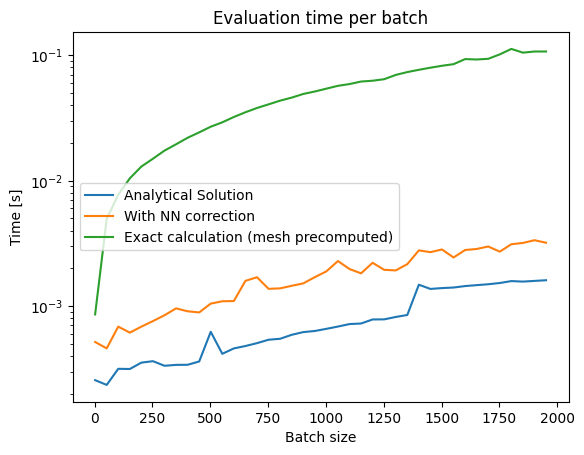

In [10]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, times_ana, label="Analytical Solution")
plt.plot(batch_sizes, times_nn, label="With NN correction")
plt.plot(batch_sizes, times_demag, label="Exact calculation (mesh precomputed)")
plt.xlabel("Batch size")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.title("Evaluation time per batch")
plt.legend()
plt.show()

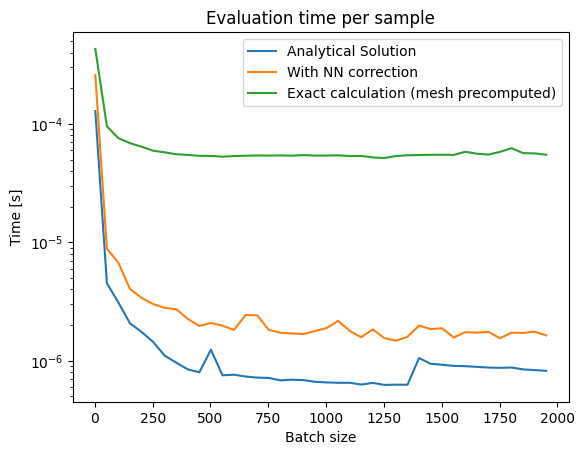

In [11]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, times_ana_sample, label="Analytical Solution")
plt.plot(batch_sizes, times_nn_sample, label="With NN correction")
plt.plot(batch_sizes, times_demag_sample, label="Exact calculation (mesh precomputed)")
plt.yscale("log")
plt.xlabel("Batch size")
plt.ylabel("Time [s]")
plt.legend()
plt.title("Evaluation time per sample")
plt.show()

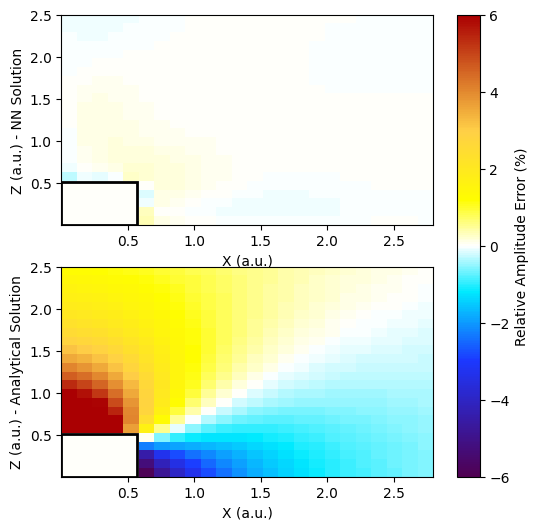

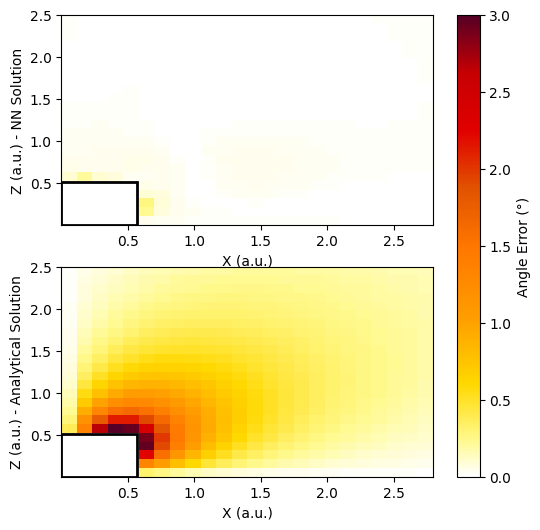

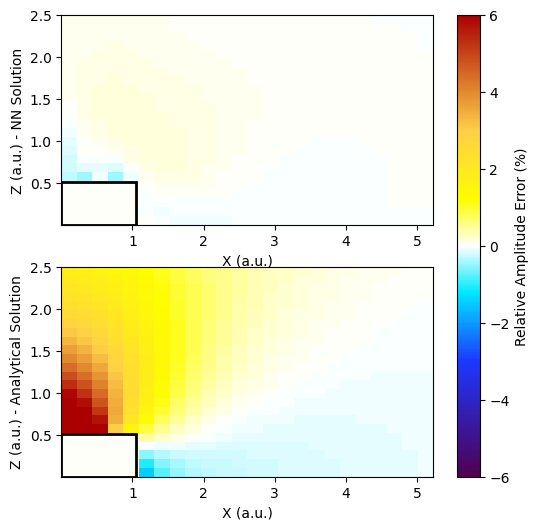

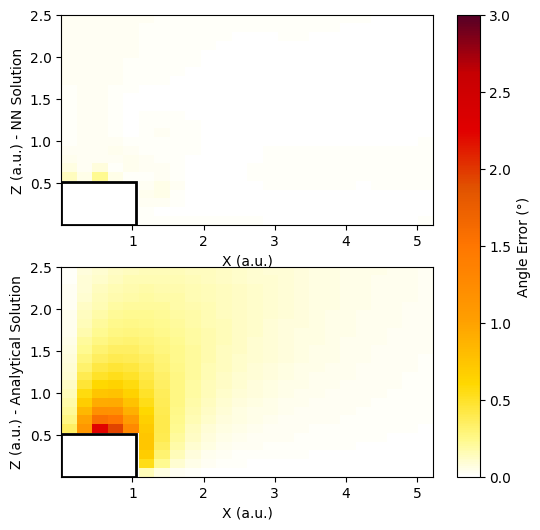

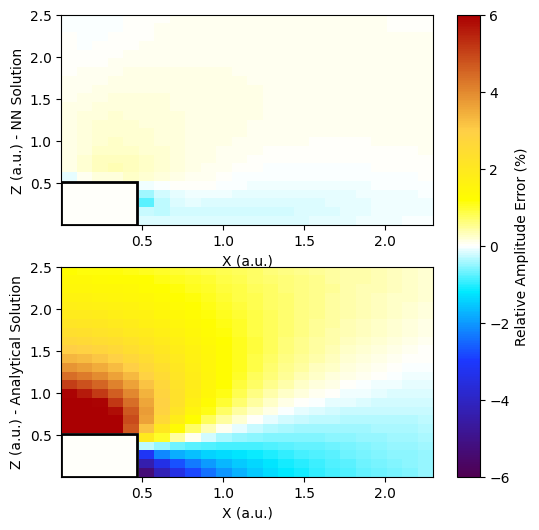

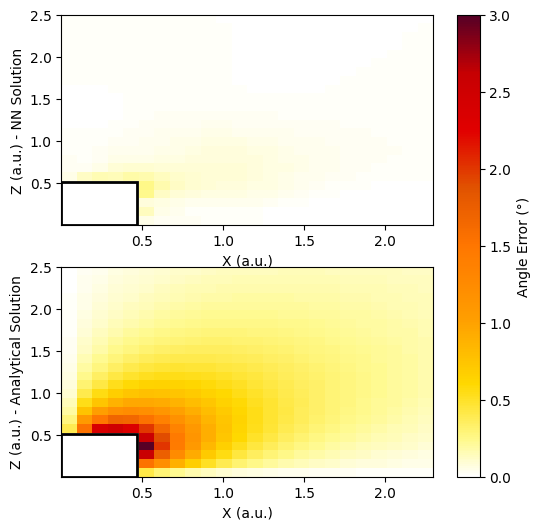

In [17]:
for i in range(3):
    plot_heatmaps(model, X[i], B[i], None, )

In [13]:
from magpylib_material_response import meshing, demag

dimension = (1, 1, 1)
polarization = (0, 0, 1)

points = X[0, :, 5:]

mag = magnet.Cuboid(dimension=dimension, polarization=polarization)
mesh = meshing.mesh_Cuboid(mag, target_elems=100)
demag.apply_demag(mesh, susceptibility=(0.1, 0.1, 0.1))

B_demag = mesh.getB(points.numpy())

In [14]:
B_pred = calcB(
    position=np.array((0, 0, 0)),
    dimension=np.array(dimension),
    polarization=np.array(polarization),
    model_path=SAVE_PATH / "best_weights.pt",
    network_type=QuaternionNet,
    hidden_dim_factor=6,
    susceptibility=np.array((0.1, 0.1, 0.1)),
    points=points.numpy(),
)

In [15]:
angle_errs = np.mean(angle_error(B_pred, B_demag))
angle_errs

np.float64(0.06847785432692917)

In [16]:
amp_errs = np.mean(relative_amplitude_error(B_pred, B_demag, return_abs=False))
amp_errs

np.float64(3.374806837985885)